# Question 1

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns
%matplotlib inline

## Plotting Functions

Through many rounds of trial and error, we saw the histogram (for numerical features) and the bar charts (for categorical features) are good indicators. So, we first present their corresponding functions, which we will use extensively throughout the report:

In [613]:
def plot_marital_bar(DF_control, DF_treated, title, ax=None, show_legend=False):
    # Plots the bar chart for the 'married' attribute, for control and treated groups.
    
    if not ax:
        _, ax1 = plt.subplots(1,1, figsize=(8, 6), dpi=150)
    else:
        ax1= ax
        
    _control_series = DF_control['married'].value_counts()\
                            .rename_axis({1: 'Married', 0:'Not Married'})
    _treated_series = DF_treated['married'].value_counts()\
                            .rename_axis({1: 'Married', 0:'Not Married'})
        
    if show_legend:
        pd.concat({'Control': _control_series, 
                   'Treated': _treated_series}, axis=1).plot.bar(ax=ax1, title=title)
    else:
        pd.concat({'Control': _control_series, 
                   'Treated': _treated_series}, axis=1).plot.bar(ax=ax1, title=title, legend=False)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0)

    
def plot_degree_bar(DF_control, DF_treated, title, ax=None, show_legend=False):
    # Plots the bar chart for the 'nodegree' attribute, for control and treated groups.

    if not ax:
        _, ax1 = plt.subplots(1,1, figsize=(8, 6), dpi=150)
    else:
        ax1= ax

    _control_series = DF_control['nodegree'].value_counts()\
                            .rename_axis({1: 'No Degree', 0:'With Degree'})
    _treated_series = DF_treated['nodegree'].value_counts()\
                            .rename_axis({1: 'No Degree', 0:'With Degree'})

    if show_legend:
        pd.concat({'Control': _control_series, 
                   'Treated': _treated_series}, axis=1).plot.bar(ax=ax1, title=title)
    else:
        pd.concat({'Control': _control_series, 
                   'Treated': _treated_series}, axis=1).plot.bar(ax=ax1, title=title, legend=False)
        
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0)


def plot_race_bar(DF_control, DF_treated, title, ax=None, show_legend=False):
    # Plots the bar chart for the '(black, hispan)' attributes, for control and treated groups.
    
    def def_race(row):
    # Encodes the (black, hispan) attributes into an integer ID.
        if row['hispan']:
            return 3
        elif row['black']:
            return 2
        else:
            return 1
    
    if not ax:
        _, ax1 = plt.subplots(1,1, figsize=(8, 6), dpi=150)
    else:
        ax1= ax
        
    # Apply the (black, hispan) => (race) transform to the control and treated dataframes.
    _control_series = DF_control.apply(def_race, axis=1).value_counts().rename_axis(
                                                           {1: 'White', 
                                                            2:'Black',
                                                            3:'Hispanic'}).sort_index()
    _treated_series = DF_treated.apply(def_race, axis=1).value_counts().rename_axis(
                                                           {1: 'White', 
                                                            2:'Black',
                                                            3:'Hispanic'}).sort_index()
    
    if show_legend:
        pd.concat({'Control': _control_series, 
                   'Treated': _treated_series}, axis=1).plot.bar(ax=ax1, title=title)
    else:
        pd.concat({'Control': _control_series, 
                   'Treated': _treated_series}, axis=1).plot.bar(ax=ax1, title=title, legend=False)
        
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0)


def plot_feature_hist(DF_control, DF_treated, feature, title, ax=None, show_legend=False, bins=None):
    # Plots the histogram of 'feature' for control and treated groups. (Used for a Numerical feature)
    
    if not ax:
        fig, (ax1) = plt.subplots(figsize=(8, 6), dpi=150)
    else:
        ax1 = ax
        
    # to have a meanigful comparison, we should set the range of histograms to
    # the same interval. We take the global min and max among the treated and 
    # the control: 
    _range = (np.min([DF_control[feature].min(),
                      DF_treated[feature].min()]), 
              np.max([DF_control[feature].max(),
                      DF_treated[feature].max()]))

    if bins is None:
        ax1.hist(DF_control[feature],20, alpha=0.5, 
                 label = 'Control', range=_range)
        ax1.hist(DF_treated[feature],20, alpha=0.5, 
                 label = 'Treated', range=_range)
    else:
        ax1.hist(DF_control[feature],20, alpha=0.5, 
                 label = 'Control', range=_range, bins=bins)
        ax1.hist(DF_treated[feature],20, alpha=0.5, 
                 label = 'Treated', range=_range, bins=bins)
        
    
    ax1.set_title(title)

    if show_legend:
        ax1.legend(loc=0, bbox_to_anchor=(1,1)) 
        

## 1. Naive Analysis

We load the dataset and analyze its features:

In [585]:
DF = pd.read_csv('lalonde.csv')
DF.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


We separate the control set and the treated set. The **treated** set includes the candidates that have received the training, while the candidates in the **control** set have not: 

In [588]:
treated = DF.loc[DF['treat'] == 1]
control = DF.loc[DF['treat'] == 0]
print(len(treated), 'participated in the job training program vs ', len(control), ' who did not.')

185 participated in the job training program vs  429  who did not.


We first plot and compare the histograms of the latest earning figures (1978) of the two groups: 

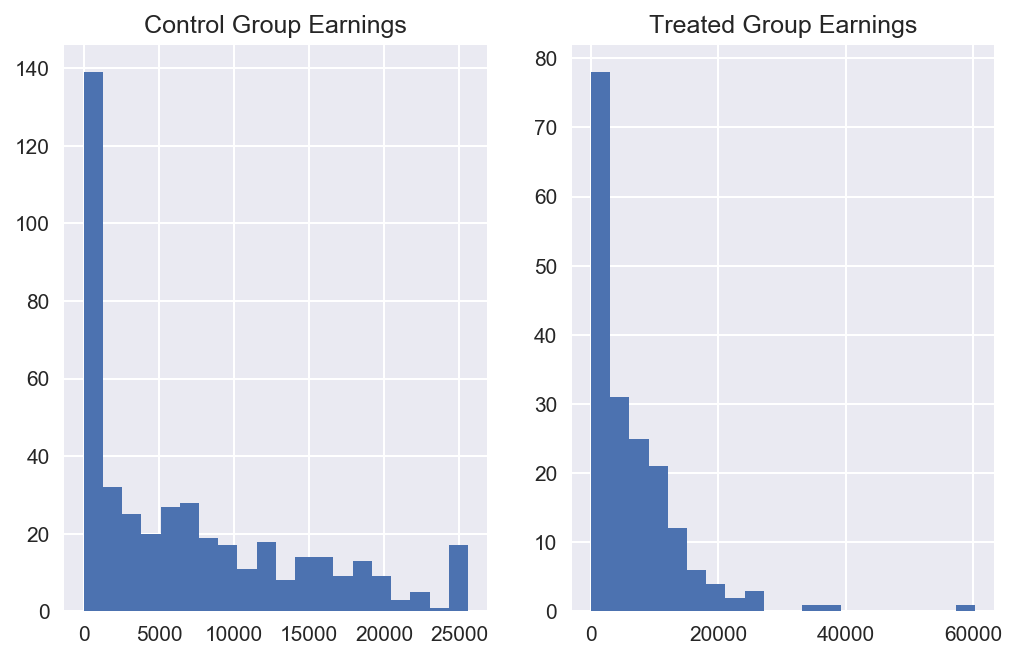

In [183]:
plt.figure(figsize=(8, 5), dpi=150)
plt.subplot(121)
plt.hist(control['re78'],20)
plt.title('Control Group Earnings')
plt.subplot(122)
plt.hist(treated['re78'], 20)
plt.title('Treated Group Earnings')
plt.show()

But the diagrams above are **not comparable**. Because both the frequency axis and the bins axes are different. So we set the range of the two histograms equally and plot them at the same time with reduced opacity:

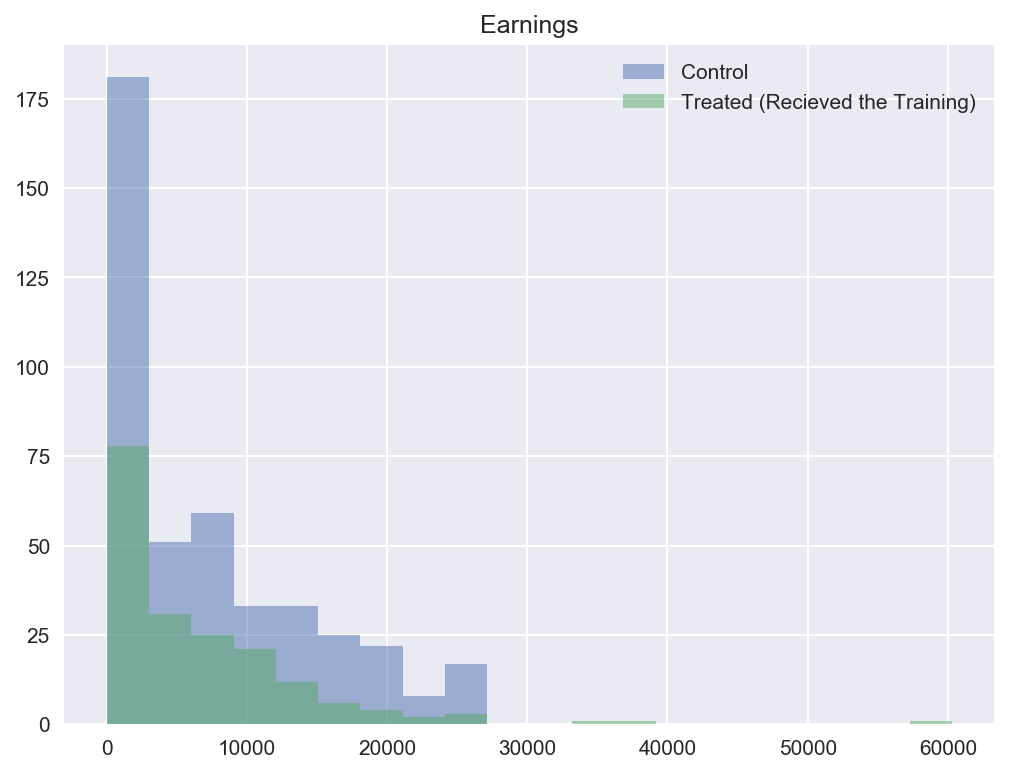

In [184]:
plt.figure(figsize=(8, 6), dpi=150)
_bins = np.linspace(0, DF['re78'].max(), 20).tolist()
plt.hist(control['re78'],20, alpha=0.5,
                       label = 'Control', range=(0, DF['re78'].max()))
plt.hist(treated['re78'],20, alpha=0.5,
                       label = 'Treated (Recieved the Training)', 
                       range=(0, DF['re78'].max()))
plt.legend()
plt.title('Earnings')
plt.show()

### The Naive Conclusion

Based on the histograms above, one might naively conclude that taking the training would actually "decrease" a candidate's chance of finding a well paying job! 

Interestingly enough, comparing the usual statistics does not help much to find the problem:

In [192]:

print('\n == Treated Group Statistics \n\n', treated['re78'].describe())
print('\n == Control Group Statistics \n\n', control['re78'].describe())


 == Treated Group Statistics 

 count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

 == Control Group Statistics 

 count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64


To better visualize this, we show the boxplots on a shared y-axis:

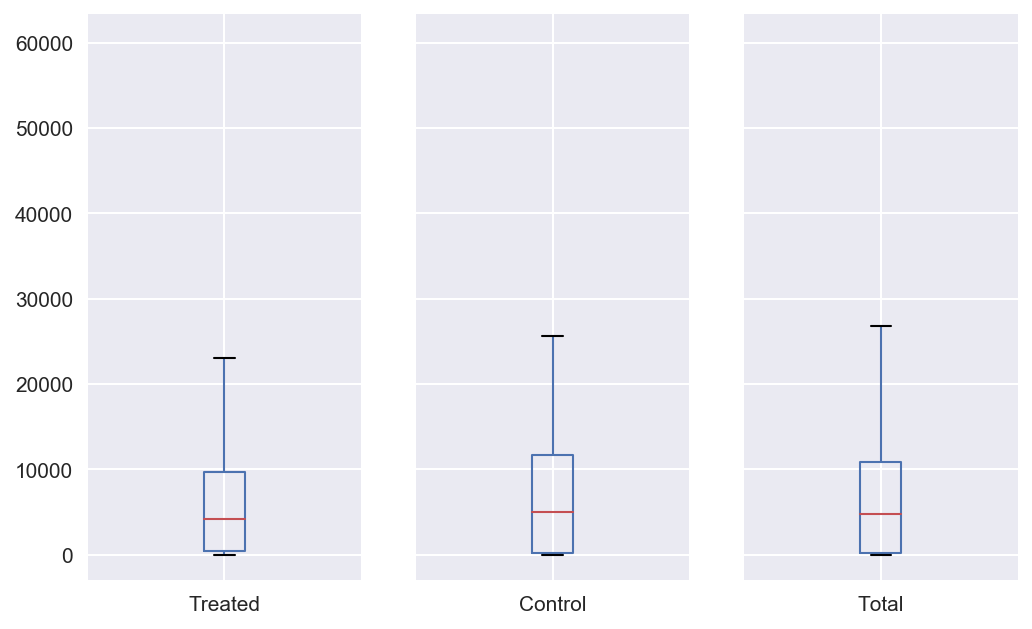

In [208]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(8,5), dpi=150)
treated.rename_axis({'re78': 'Treated'}, axis=1).boxplot(column='Treated', ax=ax1)
control.rename_axis({'re78': 'Control'}, axis=1).boxplot(column='Control', ax=ax2)
DF.rename_axis({'re78': 'Total'}, axis=1).boxplot(column='Total', ax=ax3)

plt.show()

Clearly, the statistics look similar, which begs the question:

### If the summarizations look similar, what is the problem? 

The problem is the size of each group, the control group size is more than 2 times the size of the treated group. This explains the lower frequencies for the latter. This motivates us to use a test to check whether the two distribution are really the same (the null hypothesis being that the "2 independent samples are drawn from the same continuous distribution"):

In [212]:
stat, p_value = stats.ks_2samp(treated['re78'], control['re78'])
print('Kolmogorov-Smirnov Test: \n Statistic = {}, P-Value= {} '.format(stat, p_value))

Kolmogorov-Smirnov Test: 
 Statistic = 0.09860769860769869, P-Value= 0.1527945228846811 


The P-value is not small. (for example, given a significance level of $\alpha = 0.05$ ) As such, the test is not conclusive and we cannot reject the null hypothesis. Therefore we cannot say that the two are from the same distribution. This being a dead-end we move on to compare the distributions of each feature: 

## 2. A Closer Look at the Data: Feature Analysis

We will compare the distribution of each feature between the two groups, *treated* and *control*. 

### Age

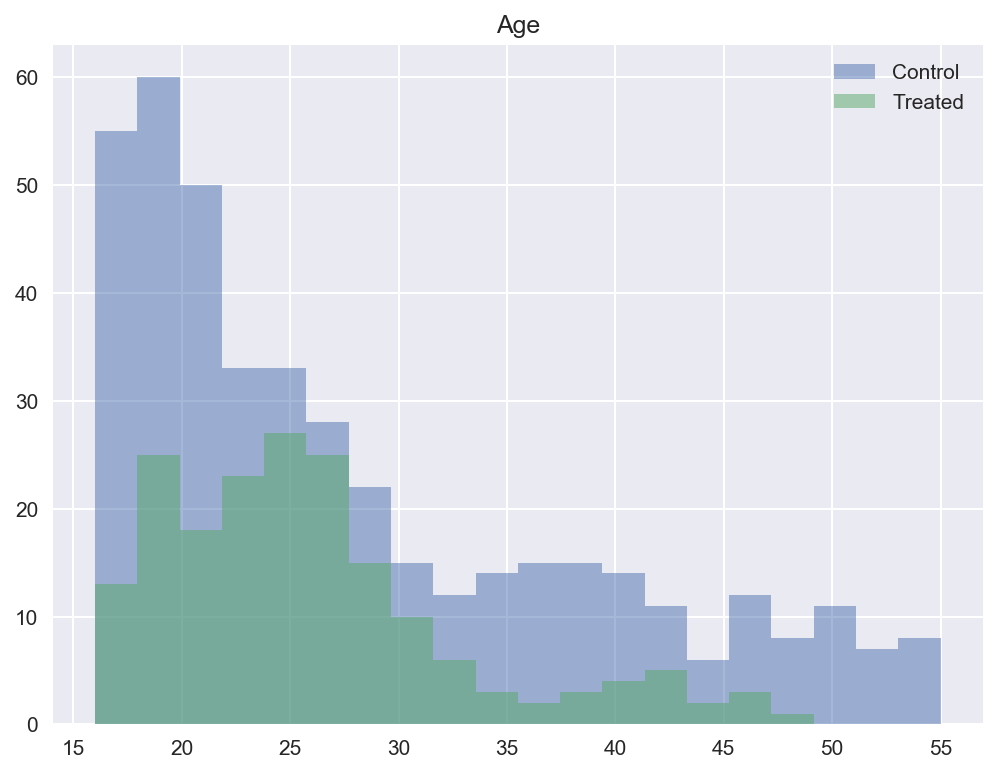

In [594]:
plot_feature_hist(control, treated, 'age', 'Age', show_legend=True)

The age distribution is clearly different. Other than the issue of unequal sizes of the size of each group, the control group's age is much more skewed to the left.

This means that a lot of youngsters have not taken the training. But this is very much expected, since such trainings are expensive and young candidates who seek their first job cannot usually pay for them. These candidates were nevertheless included in the data set and have created this tangible skew to the left. 

### Education

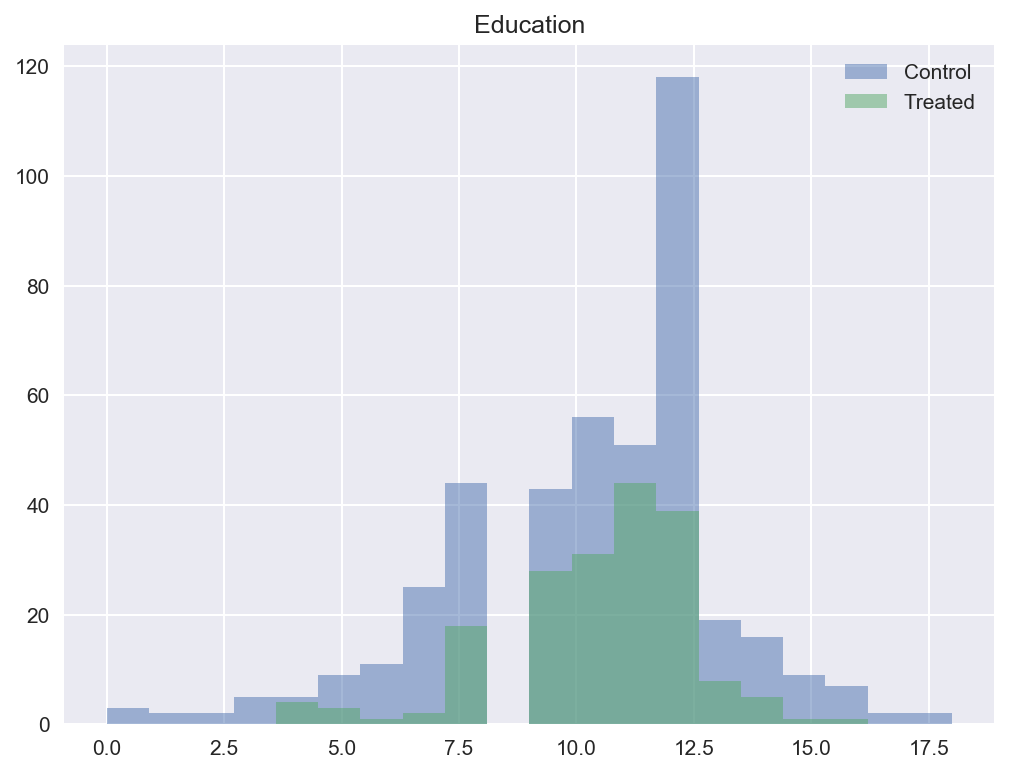

In [616]:
plot_feature_hist(control, treated, 
                  'educ', 'Education', show_legend=True)

We have the usual problem of the group sizes here. We also notice that one of the bins are completely empty in the plots above. This is an artifact of plotting the histogram of integers. This becomes apparent once we check the actual frequencies:

In [619]:
display(control['educ'].value_counts().sort_index())
display(treated['educ'].value_counts().sort_index())

0       3
1       2
2       2
3       5
4       5
5       9
6      11
7      25
8      44
9      43
10     56
11     51
12    118
13     19
14     16
15      9
16      7
17      2
18      2
Name: educ, dtype: int64

4      4
5      3
6      1
7      2
8     18
9     28
10    31
11    44
12    39
13     8
14     5
15     1
16     1
Name: educ, dtype: int64

The rest of the features (married, race (black, hispan) and nodegree) are all categorical features and as such, bar charts are more appropriate  for these variables.

### Marital Status

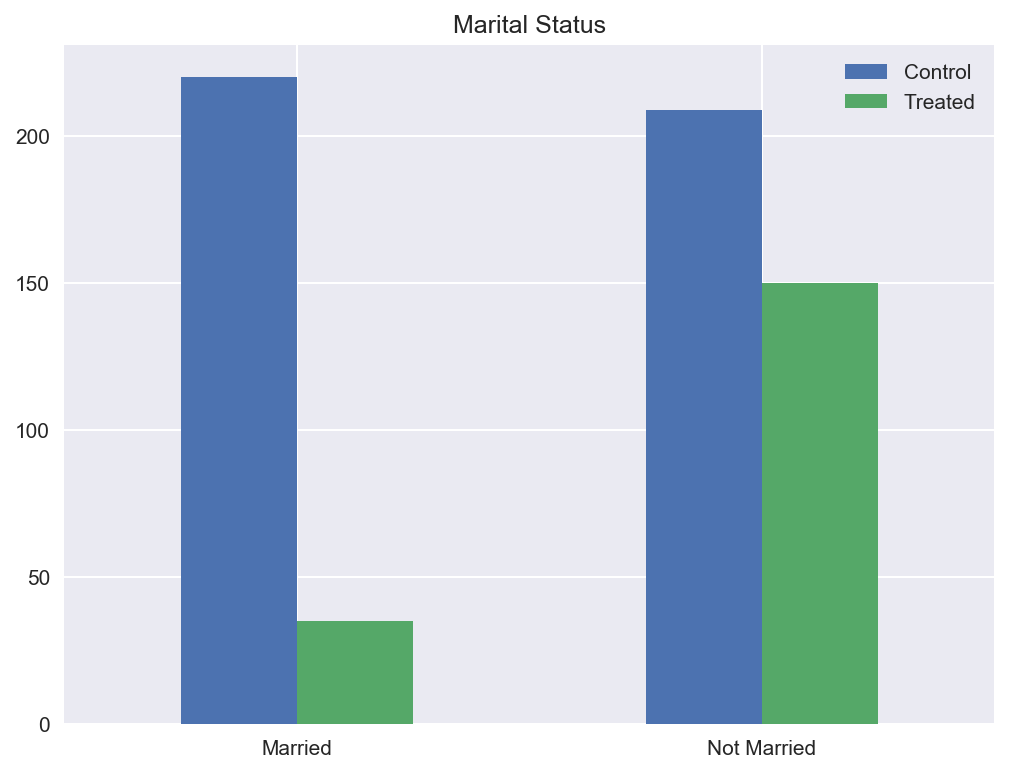

In [620]:
plot_marital_bar(control, treated, 'Marital Status', show_legend=True)

We observe a clear discrepancy between the control and the treated here. While they are slightly more married members in the Control group, there are far more non-married candidates in the treated group.  Therefore not only the trend is opposite between the groups, but the size of the difference is very significant.

### [University] Degree

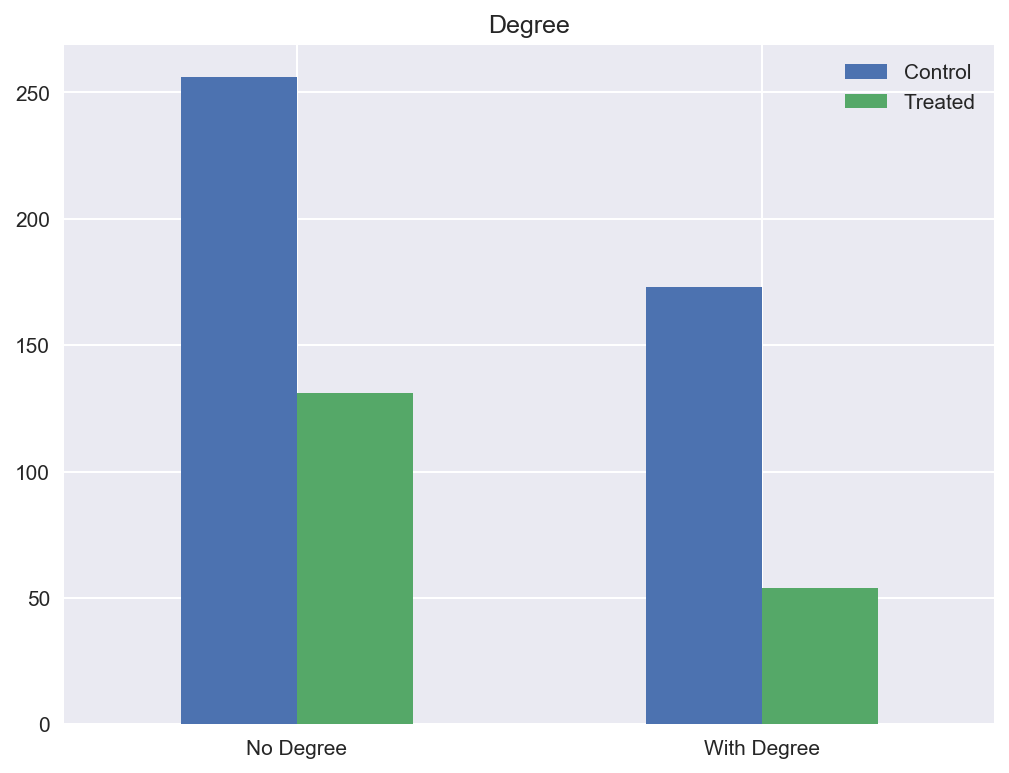

In [621]:
plot_degree_bar(control, treated, 'Degree', show_legend=True)

We observe that except for the unequal sample size problem, the treated more or less resemble the control when it comes to holding the degree or not. So, there is not much discrepancy between the two in this regard.

### Race

The race features in the dataset are the tuples (black, hispan). In the corresponding plotting function, we encode these variables into a single non-binary feature and plot the bar chart:

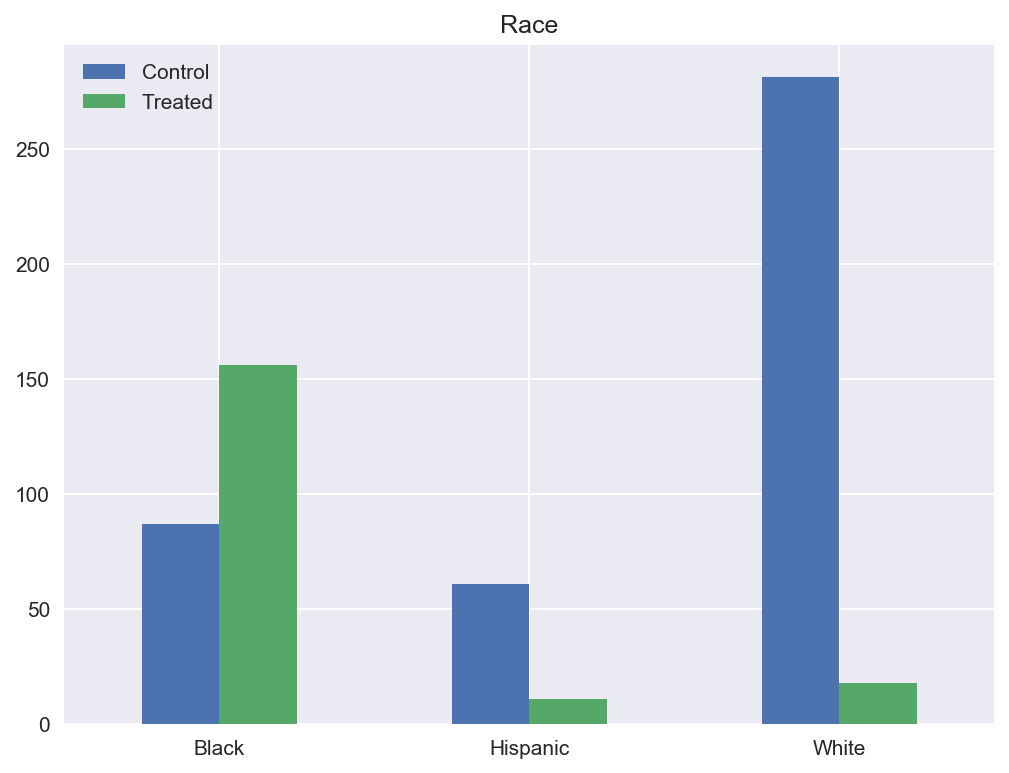

In [622]:
plot_race_bar(control, treated, 'Race', show_legend=True)

Here we see the biggest discrepancy among all features. The trends are very much different between the two groups. 
1. The blacks are unproportionately represented in the Treated group.

2. There are very few whites in the treated group, while they admittedly form the majority of candidates in the control group. 

### Conclusion

This initial feature analysis has shown us that the naive analysis has no merit because the treated group is different in many aspects from the control. The solution is to balance the groups, so that the two groups are similar to each other in every regard except having received the treatment or not. For this purpose, we use a propensity model: 

# 3. A Propensity Score Model

> Use logistic regression to estimate propensity scores for all points in the dataset. You may use sklearn to fit the logistic regression model and apply it to each data point to obtain propensity scores.

We train the classifier on the all of the data:

In [650]:
logistic = LogisticRegression(random_state=1)
selectedFeatures = DF.drop(['id','treat'], axis=1)
logistic.fit(selectedFeatures,DF['treat'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Next we calculate the propensity score of each record to be in the treated group:

In [651]:
propensity_scores = logistic.predict_proba(selectedFeatures)
DF['propensity_score']=[k[1] for k in logistic.predict_proba(selectedFeatures)]
treated = DF.loc[DF['treat'] == 1]
control = DF.loc[DF['treat'] == 0]
DF.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.447185
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.136639
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.820980
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.665541
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.673210


The propensity score is the probability of treatment assignment conditional on observed baseline characteristics.

# 4. Balancing the dataset via matching

> Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.

In [652]:
# Implementation of the Hungarian algorithm
from scipy.optimize import linear_sum_assignment
from itertools import product

We first calculate the cost matrix whose entries are the absolute difference between the propensity scores of two records:

In [653]:
# Creating the matrix of edge weights C, 
# where C[i, j] is 
#  | propensity_score(treated_i) - propensity_score(untreated_j)|

num_of_treated = len(treated)
num_of_control = len(control)

C = np.zeros((num_of_treated, num_of_control))

for i,_ in enumerate(treated.iterrows()):
    for j,_ in enumerate(control.iterrows()):
        C[i,j] = abs(treated.iloc[i]['propensity_score'] 
                    - control.iloc[j]['propensity_score'])

C

array([[ 0.37098813,  0.39609348,  0.41374432, ...,  0.3454706 ,
         0.08559184,  0.30616823],
       [ 0.06044175,  0.0855471 ,  0.10319794, ...,  0.03492422,
         0.39613822,  0.00437815],
       [ 0.74478306,  0.76988842,  0.78753926, ...,  0.71926553,
         0.28820309,  0.67996317],
       ..., 
       [ 0.34839884,  0.3735042 ,  0.39115503, ...,  0.32288131,
         0.10818113,  0.28357895],
       [ 0.36525017,  0.39035552,  0.40800636, ...,  0.33973264,
         0.0913298 ,  0.30043028],
       [ 0.38188252,  0.40698788,  0.42463872, ...,  0.35636499,
         0.07469745,  0.31706263]])

We solve the best matching problem:

In [654]:
treated_assignment, control_assginment = linear_sum_assignment(C)

We reorder the treated and control data frames according to the new matching:

In [655]:
treated_matched = treated.iloc[treated_assignment]
control_matched = control.iloc[control_assginment]
print(len(treated_matched), '?=',  len(control_matched))

185 ?= 185


## Re-evaluating the Treatment After Balancing

> Compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects. What do you observe? Are you closer to being able to draw valid conclusions now than you were before?

Having balanced the two datasets, we can compare the earnings in 78 and make a more informed decision. 

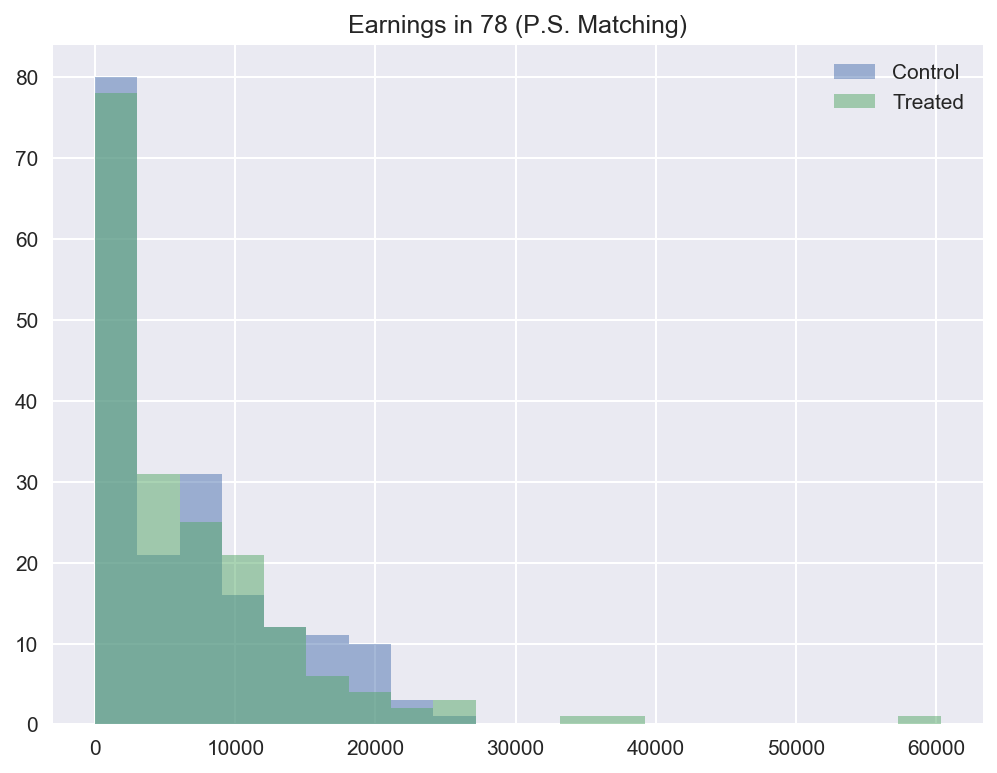

In [662]:
plot_feature_hist(control_matched, treated_matched, 're78', 'Earnings in 78 (P.S. Matching)', show_legend=True)

From the histogram, it is immediately obvious that at the very least the training does not reduce the candidate's chance of finding a well-paying job! If anything, the training helps a few candidates find very high paying jobs.

However, from the histogram, it is also obvious that the training does not make much of a difference.

We try to verify this claim, again by first looking at the distribution of features and comparing them to the previous distributions in the process.

## Re-Feature Analysis

We will compare the distribution of each feature between the two groups, *treated* and *control* this time in the **balanced dataset**. for comparison purposes, we also plot the original (unmatched) results.

### Race

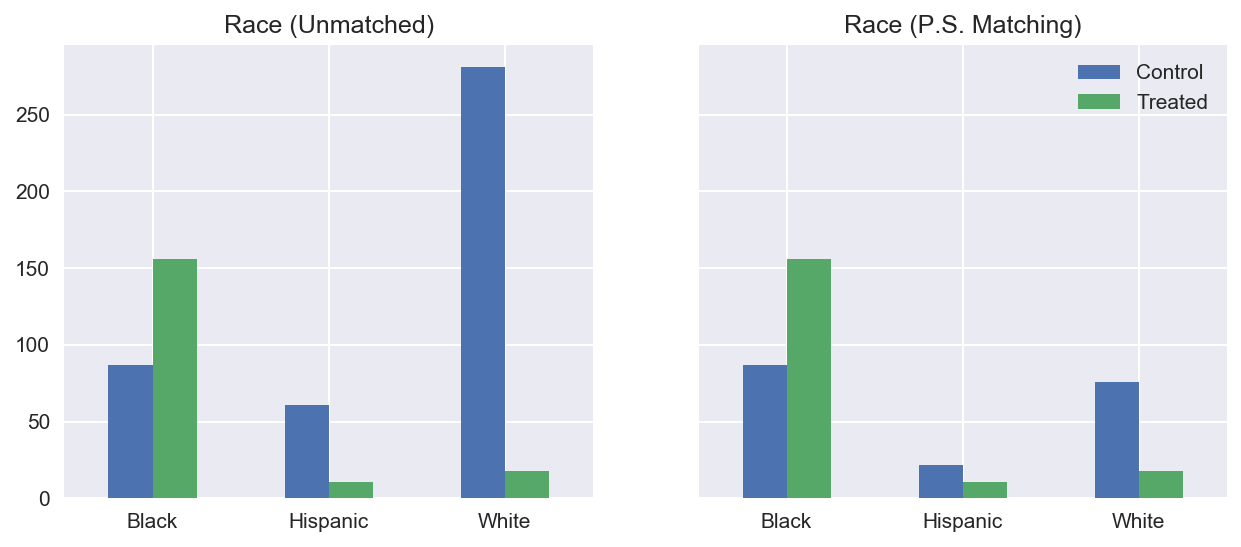

In [665]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4), 
                             dpi=150, sharey=True)

plot_race_bar(control, treated, 'Race (Unmatched)', ax=ax1)
plot_race_bar(control_matched, treated_matched, 'Race (P.S. Matching)', ax=ax2, show_legend=True)


The discrepancy between Control and Treated has reduced. But this is still far from satisfactory.

### Marital Status

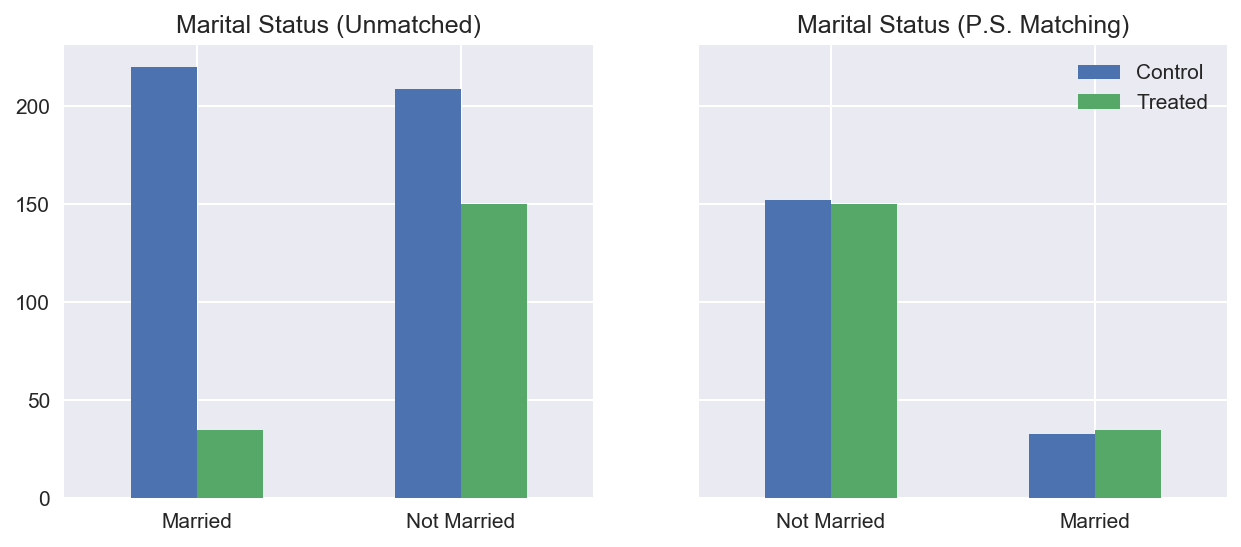

In [666]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4), 
                             dpi=150, sharey=True)

plot_marital_bar(control, treated, 'Marital Status (Unmatched)', ax=ax1)
plot_marital_bar(control_matched, treated_matched, 'Marital Status (P.S. Matching)', ax=ax2, show_legend=True)


We see that after Propensity Score (P.S.) Matching, there is almost no discrepancy between the two groups with regards to marital status. 

### Degree

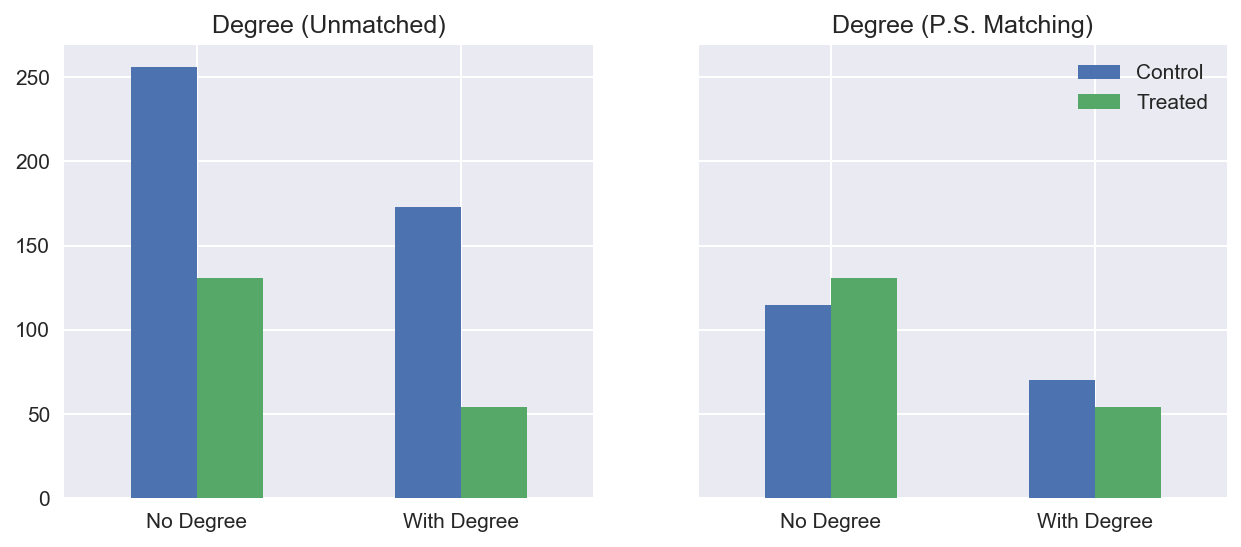

In [667]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4), 
                             dpi=150, sharey=True)

plot_degree_bar(control, treated, 'Degree (Unmatched)', ax=ax1)
plot_degree_bar(control_matched, treated_matched, 'Degree (P.S. Matching)', ax=ax2, show_legend=True)


Similar to marital status, there is now very little discrepancy between the two groups with respect to the university degree.

### Age

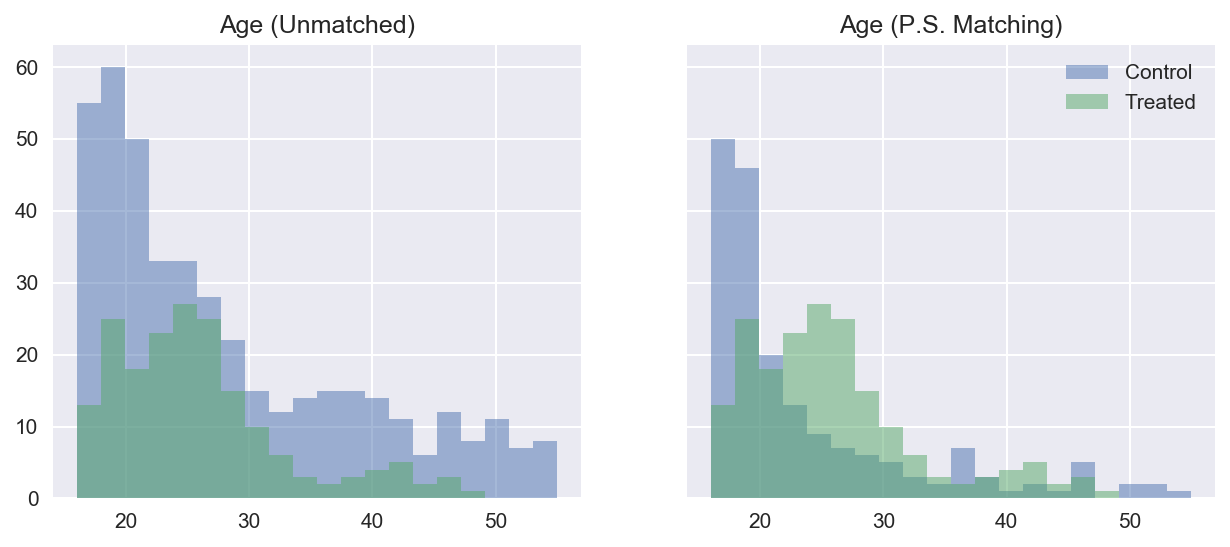

In [570]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4), 
                             dpi=150, sharey=True)

plot_feature_hist(control, treated, 'age', 'Age (Unmatched)', ax=ax1)
plot_feature_hist(control_matched, treated_matched, 'age', 'Age (P.S. Matching)', ax=ax2, show_legend=True)


The propensity score matching has not helped very much in making the age histograms similar between the treated and the control. As we explained before, we believe that the latter is not very feasible since people cannot afford such trainings before a certain age (due to the cost of such trainings). 

For the earnings features we observe that the P.S. matchings more or less equalizes the histograms: 

## Earnings in 74

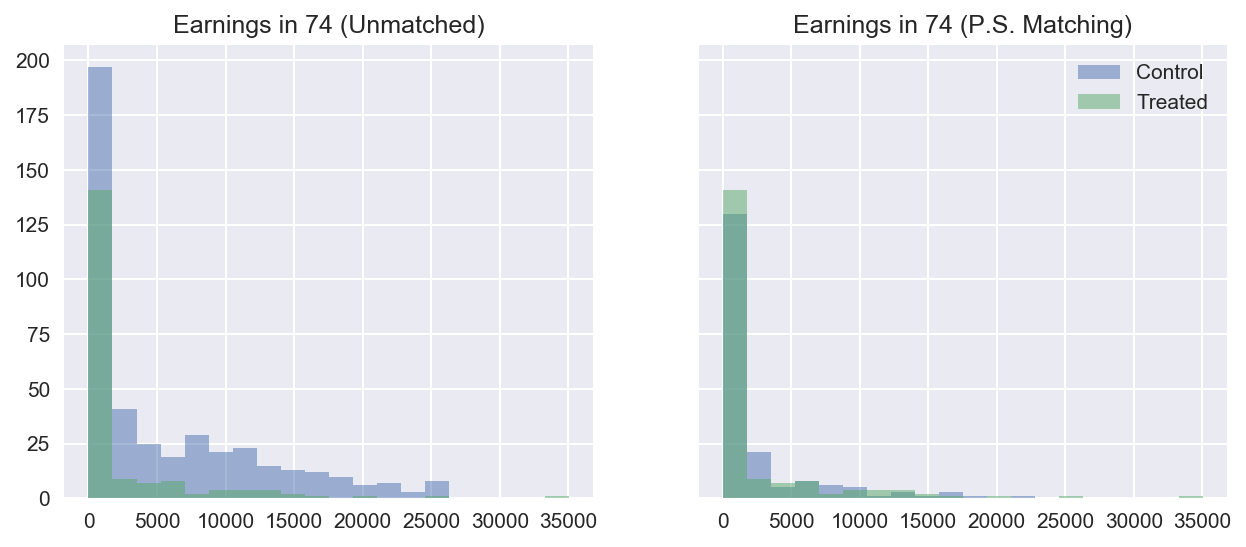

In [668]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4), 
                             dpi=150, sharey=True)

plot_feature_hist(control, treated, 're74', 'Earnings in 74 (Unmatched)', ax=ax1)
plot_feature_hist(control_matched, treated_matched, 're74', 'Earnings in 74 (P.S. Matching)', ax=ax2, show_legend=True)


## Earnings in 75

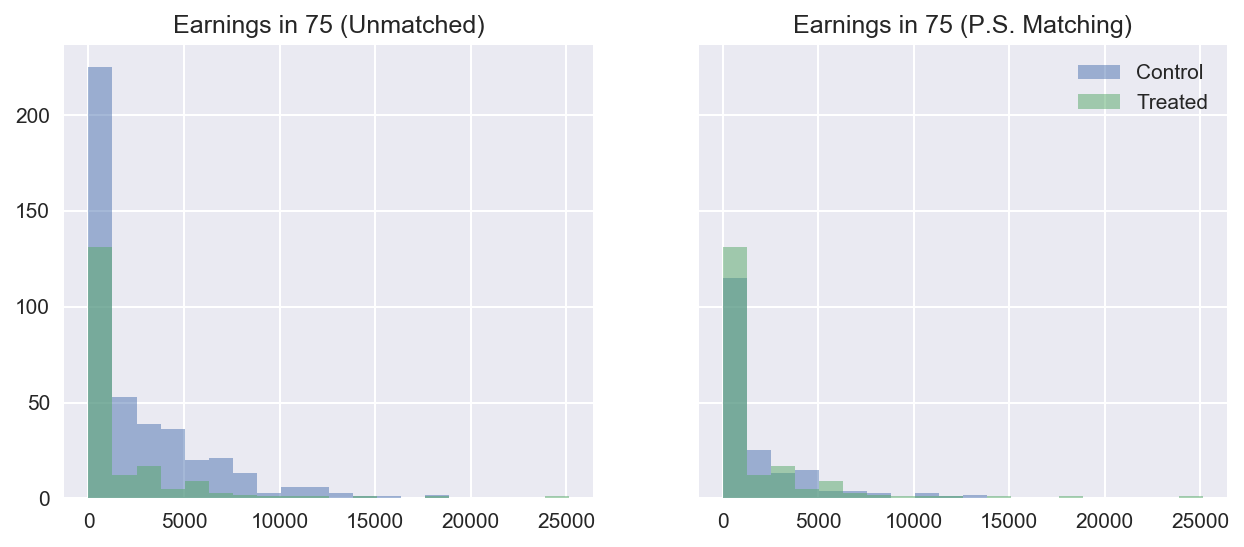

In [669]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4), 
                             dpi=150, sharey=True)

plot_feature_hist(control, treated, 're75', 'Earnings in 75 (Unmatched)', ax=ax1)
plot_feature_hist(control_matched, treated_matched, 're75', 'Earnings in 75 (P.S. Matching)', ax=ax2, show_legend=True)


## Earnings in 78

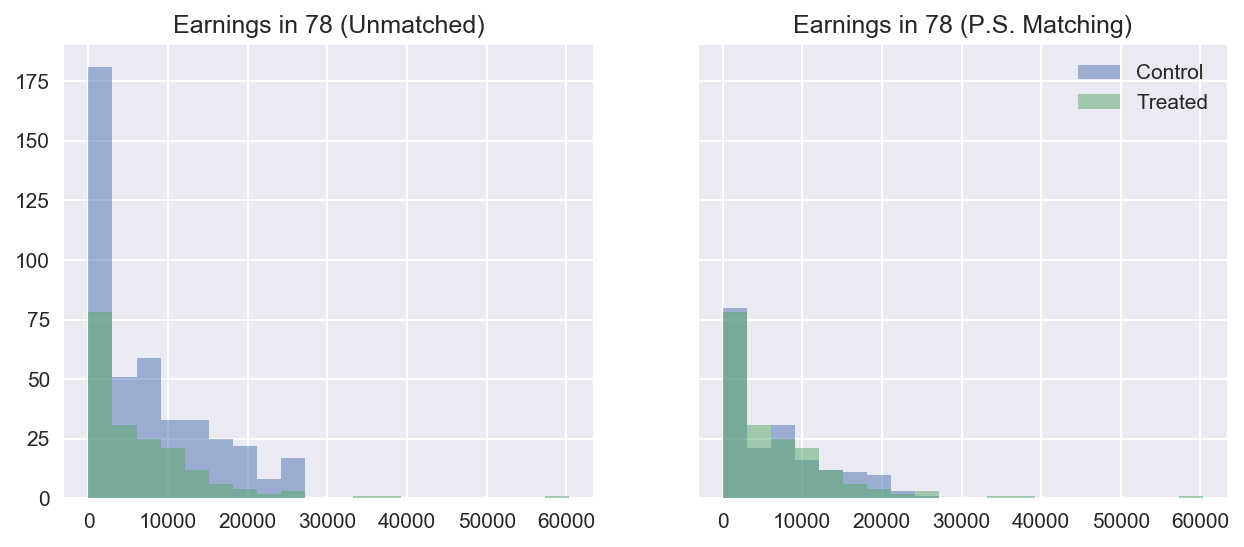

In [670]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4), 
                             dpi=150, sharey=True)

plot_feature_hist(control, treated, 're78', 'Earnings in 78 (Unmatched)', ax=ax1)
plot_feature_hist(control_matched, treated_matched, 're78', 'Earnings in 78 (P.S. Matching)', ax=ax2, show_legend=True)


## Summary: How has the Propensity Score balancing helped? 

We plot the above features in one signle plot, to get a more holistic view:

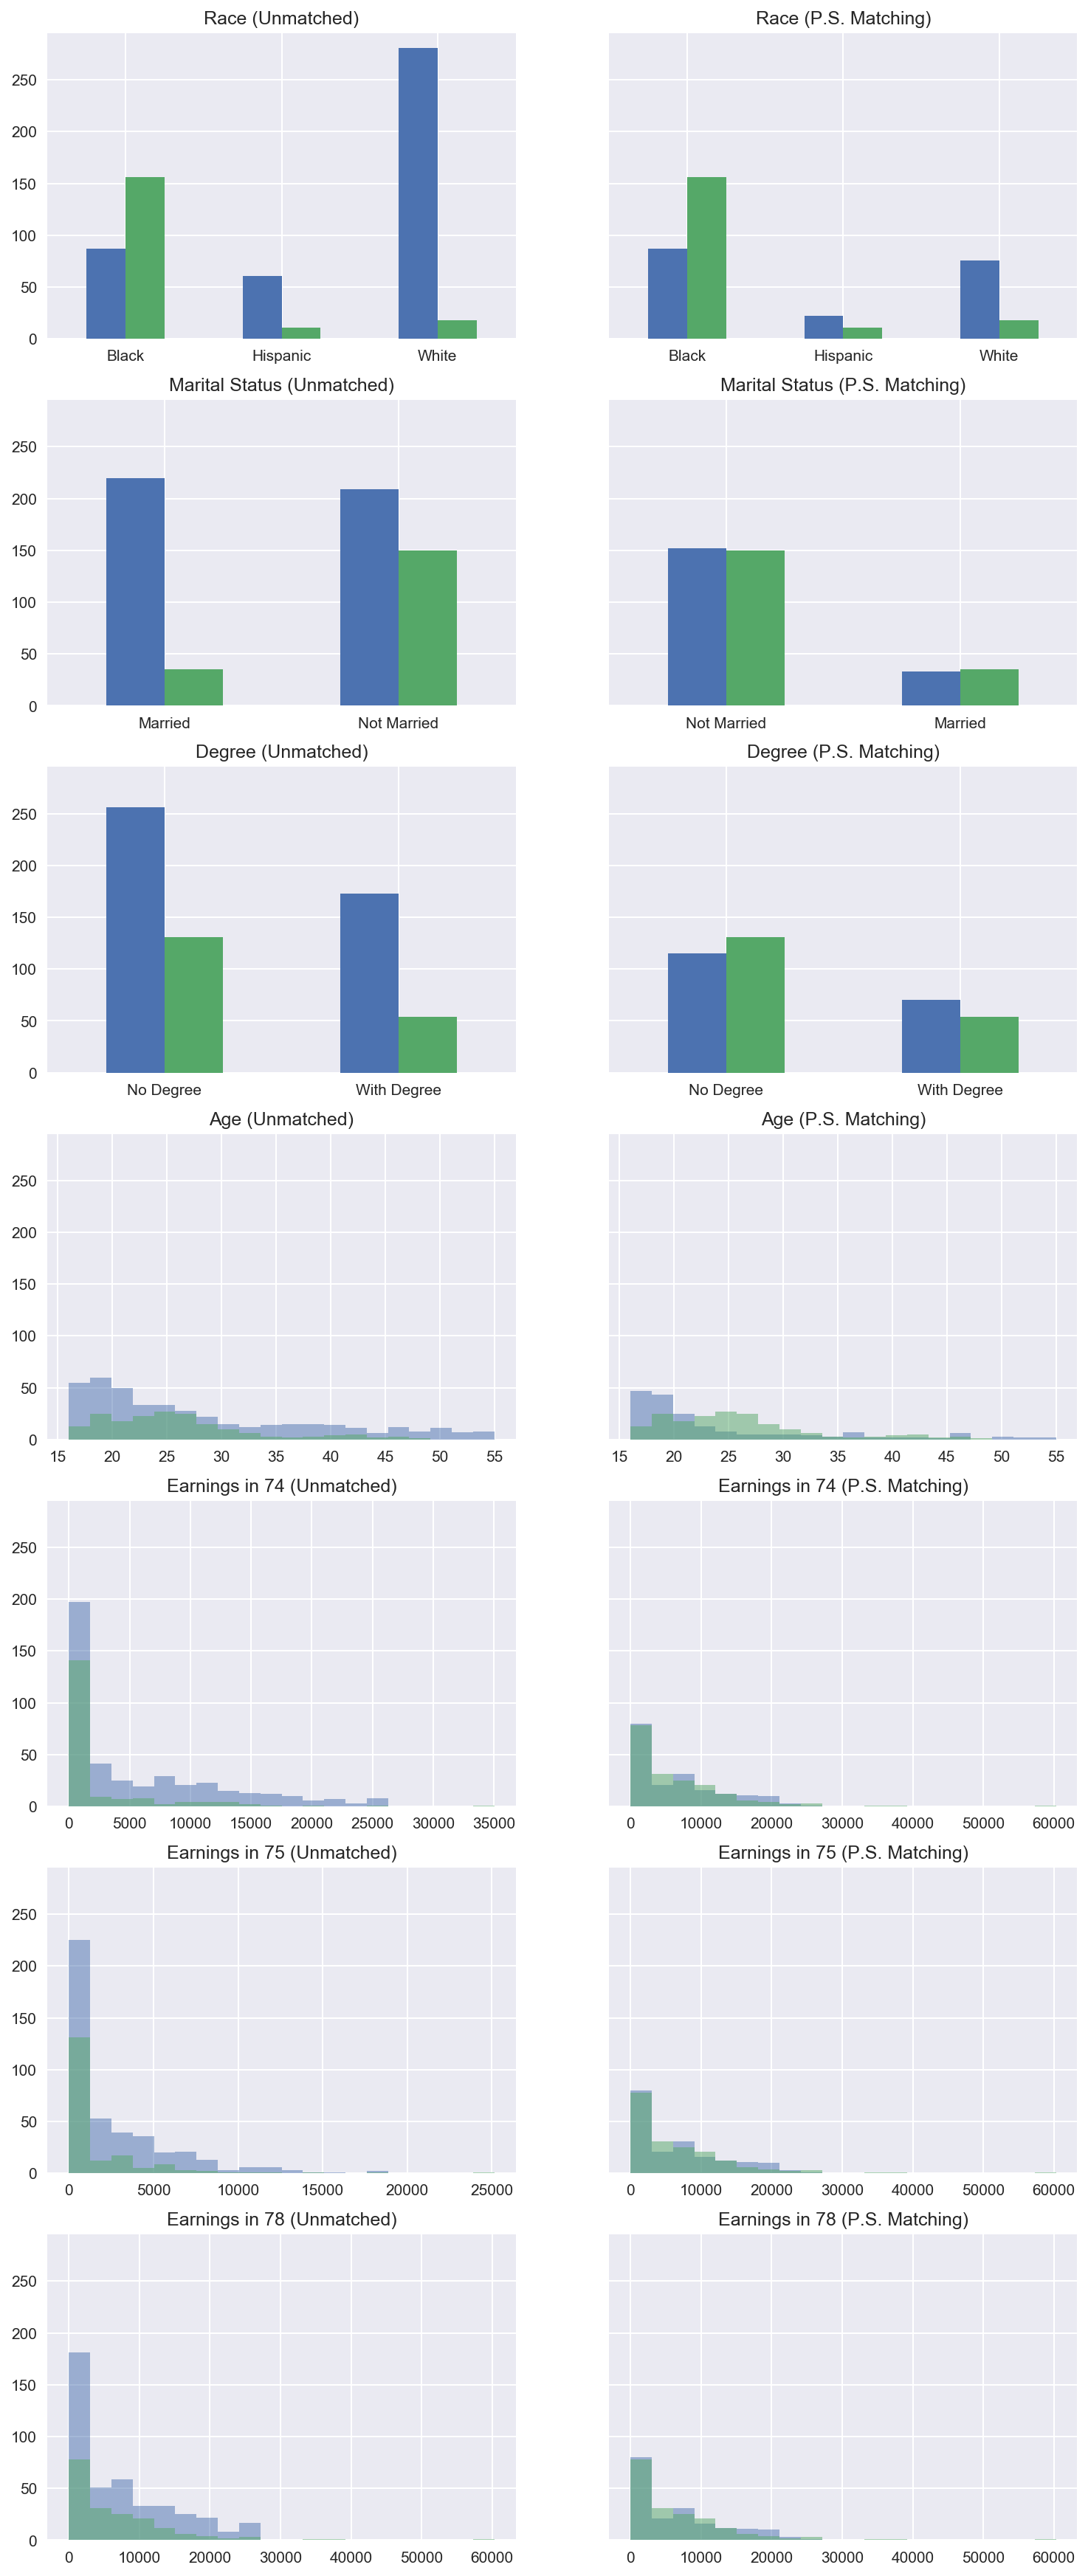

In [671]:
f, ax_array = plt.subplots(7,2, figsize=(12, 30), dpi=150, sharey=True)

# Race
plot_race_bar(control, treated, 'Race (Unmatched)', ax=ax_array[0,0])
plot_race_bar(control_matched, treated_matched, 'Race (P.S. Matching)', ax=ax_array[0,1])


# Marital Status
plot_marital_bar(control, treated, 'Marital Status (Unmatched)', ax=ax_array[1,0])
plot_marital_bar(control_matched, treated_matched, 'Marital Status (P.S. Matching)', ax=ax_array[1,1])



# Degree
plot_degree_bar(control, treated, 'Degree (Unmatched)', ax=ax_array[2,0])
plot_degree_bar(control_matched, treated_matched, 'Degree (P.S. Matching)', ax=ax_array[2,1])


# Age
plot_feature_hist(control, treated, 'age', 'Age (Unmatched)', ax=ax_array[3,0])
plot_feature_hist(control_matched, treated_matched, 'age', 'Age (P.S. Matching)', ax=ax_array[3,1])


# Earnings in 74
plot_feature_hist(control, treated, 're74', 'Earnings in 74 (Unmatched)', ax=ax_array[4,0])
plot_feature_hist(control_matched, treated_matched, 're78', 'Earnings in 74 (P.S. Matching)', ax=ax_array[4,1])


# Earnings in 75
plot_feature_hist(control, treated, 're75', 'Earnings in 75 (Unmatched)', ax=ax_array[5,0])
plot_feature_hist(control_matched, treated_matched, 're78', 'Earnings in 75 (P.S. Matching)', ax=ax_array[5,1])


# Earnings
plot_feature_hist(control, treated, 're78', 'Earnings in 78 (Unmatched)', ax=ax_array[6,0])
plot_feature_hist(control_matched, treated_matched, 're78', 'Earnings in 78 (P.S. Matching)', ax=ax_array[6,1])



## Conclusion

From the plots and analysis above we conclude that P.S. matching has helped a lot, but we are still unsatisfied with the distribution of the 'Race' feature, so we are going to match records from treated with the control, using **exact race** attributes.  

# 5. Further Matching

In [675]:
_treated = treated_matched.reset_index()
_control = control_matched.reset_index()

# We take only the inner join of the two dataframes, with exactly equal 
# (black, hispan) values:

equal_race_ind = (_treated['black'] == _control['black'])  \
                            & (_treated['hispan'] == _control['hispan'])

control_matched2 = control_matched.reset_index().loc[equal_race_ind]
treated_matched2 = treated_matched.reset_index().loc[equal_race_ind]

In [679]:
print("We have reduced the number of Control(=Treated) to", len(control_matched2),
      "records. From the original", len(control_matched), ".")

We have reduced the number of Control(=Treated) to 106 records. From the original 185 .


# 6. A Less Naive Analysis (Final Conclusion)

Having balanced the two datasets even further, we can compare the earnings in 78 and make a more informed decision. 

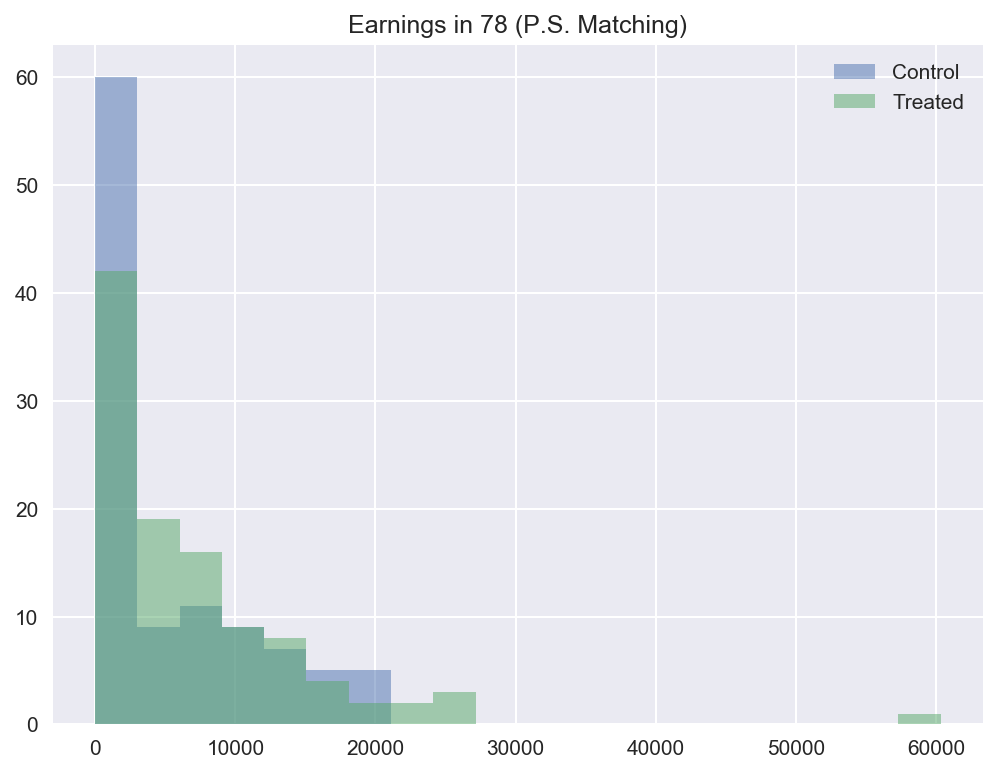

In [680]:
plot_feature_hist(control_matched2, treated_matched2, 're78', 'Earnings in 78 (P.S. Matching)', show_legend=True)

Having exactly matched the race attribute between the Control and the Treated, we observe the true effect of the training: 
1. The training is effective in reducing the unemployment (and/or very low paying jobs): There are around 60/106 people in that category who are from the control group, but this number reduces to 42 in the treated (trained) group.

2. The training is most effective in getting low level (low paying) jobs, with almost a two-fold increase in number of jobs that pay less than 10K. 

3. The training is not very effective for people in medium-paying jobs. 

4. The training is successful in helping people with medium paying jobs (less than 20K) to find higher paying jobs.

5. The training is marginally successful in helping some (potentially outstanding candidates) to find very high paying jobs.


Finally we verify the distribution  of the features under the new matching:

### Feature Distributions after the P.S. and the Exact Race Matching: 

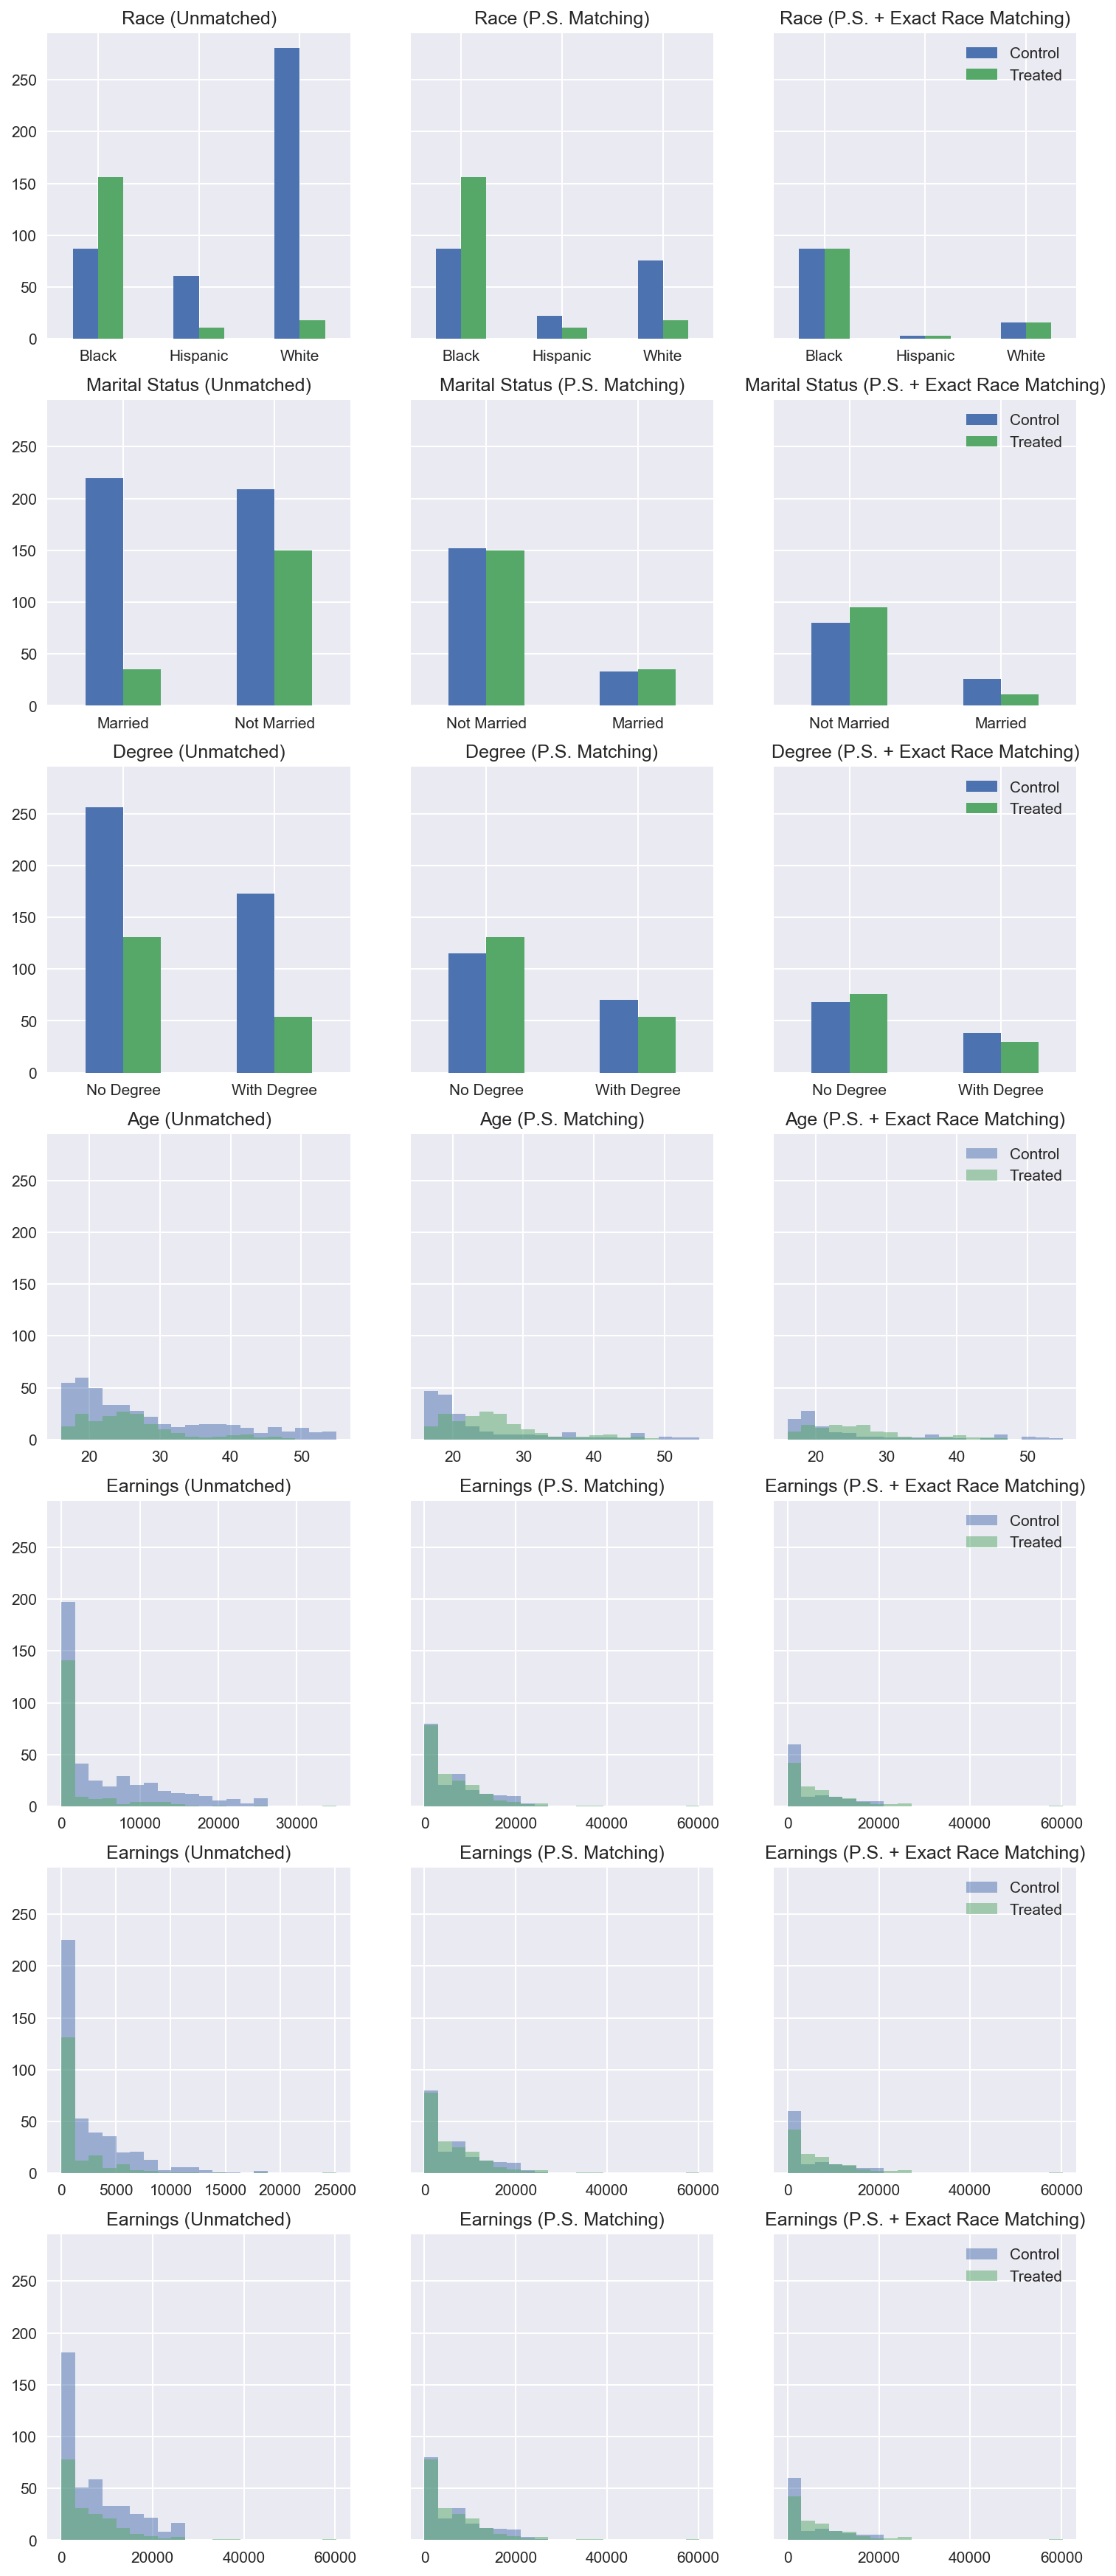

In [682]:
f, ax_array = plt.subplots(7,3, figsize=(12, 30), dpi=150, sharey=True)

# Race
plot_race_bar(control, treated, 'Race (Unmatched)', ax=ax_array[0,0])
plot_race_bar(control_matched, treated_matched, 'Race (P.S. Matching)', ax=ax_array[0,1])
plot_race_bar(control_matched2, treated_matched2, 'Race (P.S. + Exact Race Matching)', ax=ax_array[0,2], 
              show_legend=True)

# Marital Status
plot_marital_bar(control, treated, 'Marital Status (Unmatched)', ax=ax_array[1,0])
plot_marital_bar(control_matched, treated_matched, 'Marital Status (P.S. Matching)', ax=ax_array[1,1])
plot_marital_bar(control_matched2, treated_matched2, 'Marital Status (P.S. + Exact Race Matching)', 
                 ax=ax_array[1,2], show_legend=True)


# Degree
plot_degree_bar(control, treated, 'Degree (Unmatched)', ax=ax_array[2,0])
plot_degree_bar(control_matched, treated_matched, 'Degree (P.S. Matching)', ax=ax_array[2,1])
plot_degree_bar(control_matched2, treated_matched2, 'Degree (P.S. + Exact Race Matching)', 
                ax=ax_array[2,2], show_legend=True)

# Age
plot_feature_hist(control, treated, 'age', 'Age (Unmatched)', ax=ax_array[3,0])
plot_feature_hist(control_matched, treated_matched, 'age', 'Age (P.S. Matching)', ax=ax_array[3,1])
plot_feature_hist(control_matched2, treated_matched2, 'age', 'Age (P.S. + Exact Race Matching)',
                  ax=ax_array[3,2], show_legend=True)

# Earnings in 74
plot_feature_hist(control, treated, 're74', 'Earnings (Unmatched)', ax=ax_array[4,0])
plot_feature_hist(control_matched, treated_matched, 're78', 'Earnings (P.S. Matching)', ax=ax_array[4,1])
plot_feature_hist(control_matched2, treated_matched2, 're78', 'Earnings (P.S. + Exact Race Matching)',
                  ax=ax_array[4,2], show_legend=True)

# Earnings in 75
plot_feature_hist(control, treated, 're75', 'Earnings (Unmatched)', ax=ax_array[5,0])
plot_feature_hist(control_matched, treated_matched, 're78', 'Earnings (P.S. Matching)', ax=ax_array[5,1])
plot_feature_hist(control_matched2, treated_matched2, 're78', 'Earnings (P.S. + Exact Race Matching)',
                  ax=ax_array[5,2], show_legend=True)

# Earnings
plot_feature_hist(control, treated, 're78', 'Earnings (Unmatched)', ax=ax_array[6,0])
plot_feature_hist(control_matched, treated_matched, 're78', 'Earnings (P.S. Matching)', ax=ax_array[6,1])
plot_feature_hist(control_matched2, treated_matched2, 're78', 'Earnings (P.S. + Exact Race Matching)',
                  ax=ax_array[6,2], show_legend=True)

We observe that the discrepancy in the race attribute is gone. Interestingly, with the new matching, we make the distribution of the marital status feature a bit worse than before, but it's not very significant. Meanwhile the gains in all of the features, especially the earnings are very significant.

From this, we conclude that our findings hold, that 

> **The training is effective in general, but to different degrees for different people according to their current employment status.**